<a href="https://colab.research.google.com/github/Graur/mipt/blob/master/%D0%93%D1%80%D0%B0%D1%83%D1%80_%D0%90%D0%BD%D0%B4%D1%80%D0%B5%D0%B9_%D0%9A%D0%BE%D0%BD%D1%81%D1%82%D0%B0%D0%BD%D1%82%D0%B8%D0%BD%D0%BE%D0%B2%D0%B8%D1%87_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B8%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D1%8F_%D0%A1%D0%BE%D1%80%D0%B5%D0%B2%D0%BD%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B8__DS_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [2]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1516,p14707024B,Smart Coupe,economy,petrol,4.42,2015,91880,2018,66.05,engine_ignition
1787,U-6432729p,Smart ForTwo,economy,petrol,6.16,2017,111958,2016,47.28,engine_check
1408,o25113856w,Kia Sportage,standart,petrol,3.42,2013,41053,2020,36.87,gear_stick
1715,f11034155i,VW Polo VI,economy,petrol,4.26,2014,67500,2021,54.92,engine_ignition
268,l21849080k,Skoda Rapid,economy,petrol,4.26,2017,110513,2017,22.15,break_bug


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [3]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
86610,l10266491b,G-2033856I,p1o,2020-03-11,6.16,55,710,39,79.171156,0,1.881236e+03,0,3.528130,-24.824
9304,R18349169K,A13722291q,i1q,2020-02-13,7.56,35,415,41,76.000000,2,8.601900e+02,0,-7.626231,-4.700
100444,J18812572F,H-2218041i,V1r,2020-01-25,6.50,22,171,44,83.000000,1,1.030537e+03,0,-7.427190,39.753
349494,m10713201f,Z-1984492i,H1D,2020-02-24,5.32,14,162,46,84.000000,1,1.361289e+02,0,29.385267,-8.814
234357,w21212681q,Q-9015964Z,J1t,2020-03-22,3.79,22064,353019,55,103.656530,0,1.247777e+06,0,-8.040220,38.869


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [4]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
14831,59,8.2,1728,6.0,M10805156S,0,2021-8-9
2020,20,9.2,955,17.0,D11167918d,1,2018-12-11
14174,23,8.6,1010,8.0,b12652979Z,1,2020-11-6
13391,37,8.5,587,11.0,R16306831H,0,2019-6-13
7787,31,8.5,1257,8.0,G11222885m,1,2018-9-21


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [5]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
29822,y-3838245t,SJ,2018-10-30 17:29,reparking,1.0,29
95971,a56690336a,TP,2020-1-15 21:40,repair,4.5,9
67866,h10860992T,YR,2020-11-14 16:15,repair,5.0,12
39119,P10296494R,YS,2020-1-2 0:12,refuel_check,1.0,19
41880,Z15287780R,IB,2019-7-10 13:25,repair,5.0,31


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [ ]:
# Пример расчета одного признака
# rides_info.groupby('car_id', as_index=False).agg(
#     mean_rating = ('rating', 'mean'),
#     # ... еще признаки
# )

# df = pd.merge(...) # Соедините полученный датасет с фичами с основным датасетом

# YOUR CODE HERE
rides_grouped = rides_info.groupby('car_id').agg(
    min_rating=('rating', 'min'),
    mean_rating=('rating', 'mean'),
    total_distance=('distance', 'sum'),
    max_speed=('speed_max', 'max'),
    total_rides=('ride_id', 'count'),
    user_id=('user_id', lambda x: list(x))
)


rides_grouped['mean_duration'] = rides_info.groupby('car_id')['ride_duration'].mean()
rides_grouped['mean_cost'] = rides_info.groupby('car_id')['ride_cost'].mean()
rides_grouped['mean_user_ride_quality'] = rides_info.groupby('car_id')['user_ride_quality'].mean()

rides_grouped.reset_index(inplace=True)

print(rides_grouped.head())


       car_id  min_rating  mean_rating  total_distance   max_speed  \
0  A-1049127W         0.1     4.255172    1.125753e+07  179.729652   
1  A-1079539w         0.1     4.088046    1.912765e+07  184.505566   
2  A-1162143G         0.1     4.662299    2.995194e+06  180.000000   
3  A-1228282M         0.1     4.225172    1.793685e+07  182.446070   
4  A-1339912r         0.1     4.690115    1.202552e+07  152.000000   

   total_rides                                            user_id  \
0          174  [o52317055h, H41298704y, v88009926E, t14229455...   
1          174  [k91911033h, h75950158f, K14711042t, P20456464...   
2          174  [X21167121X, o11160326l, w48163041v, y64330631...   
3          174  [F17845906t, u23043461b, B15265668y, c88986152...   
4          174  [X12967899W, s81460917M, q19715188u, t12548491...   

   mean_duration     mean_cost  mean_user_ride_quality  
0    1289.034483  15201.436782                0.226325  
1    2148.810345  27007.477011                1.42

In [ ]:
rides_grouped_exploded = rides_grouped.explode('user_id')
merged_data = pd.merge(rides_grouped_exploded, driver_info, on='user_id', how='left')
merged_data = pd.merge(merged_data, fix_info, on='car_id', how='left')
print(merged_data.head())


       car_id  min_rating  mean_rating  total_distance   max_speed  \
0  A-1049127W         0.1     4.255172    1.125753e+07  179.729652   
1  A-1049127W         0.1     4.255172    1.125753e+07  179.729652   
2  A-1049127W         0.1     4.255172    1.125753e+07  179.729652   
3  A-1049127W         0.1     4.255172    1.125753e+07  179.729652   
4  A-1049127W         0.1     4.255172    1.125753e+07  179.729652   

   total_rides     user_id  mean_duration     mean_cost  \
0          174  o52317055h    1289.034483  15201.436782   
1          174  o52317055h    1289.034483  15201.436782   
2          174  o52317055h    1289.034483  15201.436782   
3          174  o52317055h    1289.034483  15201.436782   
4          174  o52317055h    1289.034483  15201.436782   

   mean_user_ride_quality  ...  user_rating  user_rides  user_time_accident  \
0                0.226325  ...          8.0         228                 9.0   
1                0.226325  ...          8.0         228           

### Идеи для новых признаков

1.   Из датасета rides_info:

    - Среднее время поездки за все поездки машины.
    - Среднее расстояние за одну поездку.
    - Количество поездок, в которых были остановки (паузы).
    - Доля поездок с дозаправкой (поле refueling).
    - Средний рейтинг, который водители ставили за поездки на данной машине.
    - Общее количество пользователей, которые использовали данную машину.

2.  Из датасета driver_info:

    - Среднее время с момента первой поездки на данной машине.
    - Количество инцидентов на каждую машину (user_time_accident).
    - Средний рейтинг, который водитель получил за все поездки на данной машине.

3.  Из датасета fix_info:

    - Общее количество ремонтов для каждой машины.
    - Среднее время между ремонтами.
    - Среднее время, требуемое на ремонт машины.



In [ ]:
# YOUR CODE HERE
# Из предложенных признаков, наиболее полезными могут быть те, которые содержат информацию о различных аспектах
# состояния машины или поведении водителя, которая может быть связана с вероятностью возникновения поломок или других проблем
merged_data['driver_age'] = merged_data['age']
merged_data['total_user_rating'] = merged_data['user_rating']
merged_data['driver_total_rides'] = merged_data['user_rides']

merged_data['fix_degree'] = merged_data['destroy_degree']
merged_data['fix_type'] = merged_data['work_type']
merged_data['fix_duration'] = merged_data['work_duration']

print(merged_data.head())

       car_id  min_rating  mean_rating  total_distance   max_speed  \
0  A-1049127W         0.1     4.255172    1.125753e+07  179.729652   
1  A-1049127W         0.1     4.255172    1.125753e+07  179.729652   
2  A-1049127W         0.1     4.255172    1.125753e+07  179.729652   
3  A-1049127W         0.1     4.255172    1.125753e+07  179.729652   
4  A-1049127W         0.1     4.255172    1.125753e+07  179.729652   

   total_rides     user_id  mean_duration     mean_cost  \
0          174  o52317055h    1289.034483  15201.436782   
1          174  o52317055h    1289.034483  15201.436782   
2          174  o52317055h    1289.034483  15201.436782   
3          174  o52317055h    1289.034483  15201.436782   
4          174  o52317055h    1289.034483  15201.436782   

   mean_user_ride_quality  ...          fix_date     work_type  \
0                0.226325  ...   2020-10-14 14:0     reparking   
1                0.226325  ...   2019-6-27 16:56  refuel_check   
2                0.226325 

* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [6]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.6 MB/s eta 0:00:00


In [ ]:
# YOUR CODE HERE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
import shap
used_features = ["min_rating",  "mean_rating",  "total_distance",   "max_speed"]
unused_features = set(merged_data.columns) - set(used_features)
merged_data.drop(unused_features, axis=1, inplace=True)

# Линейная корреляция
correlation_matrix = merged_data.corr()
print("Линейная корреляция с целевой переменной:\n", correlation_matrix)



Линейная корреляция с целевой переменной:
                 min_rating  mean_rating  total_distance  max_speed
min_rating        1.000000     0.382246       -0.051616  -0.287692
mean_rating       0.382246     1.000000       -0.136768  -0.592398
total_distance   -0.051616    -0.136768        1.000000   0.129074
max_speed        -0.287692    -0.592398        0.129074   1.000000


In [ ]:
# # Permutation importance
X = merged_data.drop(['max_speed'], axis=1)
y = merged_data['max_speed']
model = RandomForestRegressor(random_state=42)
model.fit(X, y)
perm_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nPermutation importance:\n", perm_importance)


Permutation importance:
 mean_rating       0.715356
total_distance    0.209983
min_rating        0.074661
dtype: float64


In [ ]:
# # SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(shap_importance, index=X.columns).sort_values(ascending=False)
print("\nSHAP values:\n", shap_importance)

Выводы:

1)   Линейная корреляция с целевой переменной:

  - min_rating имеет положительную корреляцию с mean_rating, что означает, что более низкие оценки чаще встречаются вместе с более высокими оценками.

  - mean_rating имеет относительно сильную положительную корреляцию с min_rating и отрицательную корреляцию с max_speed. Это может указывать на то, что более высокие средние оценки чаще встречаются с более высокими минимальными оценками и более низкими максимальными скоростями.


  - total_distance имеет слабую положительную корреляцию с max_speed, что может означать, что более длинные расстояния чаще встречаются с более высокими максимальными скоростями.

2)    Permutation importance:
- mean_rating имеет самый высокий показатель важности. Это означает, что изменение этого признака приводит к наибольшим изменениям в предсказаниях модели. Таким образом, средняя оценка является наиболее важным признаком для модели.

- total_distance имеет второй по важности показатель, но он значительно ниже, чем у mean_rating.

- min_rating имеет наименьший показатель важности, что означает, что изменения в этом признаке вносят наименьший вклад в предсказания модели.

В целом, можно сделать вывод, что средняя оценка (mean_rating) является наиболее важным признаком для предсказания целевой переменной, а также что она имеет наибольшую корреляцию с другими признаками. Расстояние (total_distance) также оказывает некоторое влияние, хотя и меньше, чем средняя оценка. Минимальная оценка (min_rating) имеет меньшее значение и важность по сравнению с другими признаками.

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `y` таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [7]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.2 MB/s eta 0:00:00


In [8]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
car_train.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel


In [ ]:
features2drop = ['car_id'] # то, что надо выбросить
targets = ['target_class', 'target_reg'] # таргеты
cat_features = ['car_type', 'fuel_type', 'model'] # категориальные признаки

num_features = ['car_rating', 'year_to_start', 'riders', 'year_to_work'] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 3 ['car_type', 'fuel_type', 'model']
Числовые признаки: 4 ['car_rating', 'year_to_start', 'riders', 'year_to_work']
Целевые переменные ['target_class', 'target_reg']


In [ ]:
# YOUR CODE HERE
features = [i for i in car_train.columns if (i not in targets and i not in features2drop)]

X = car_train[features].drop(targets, axis=1, errors='ignore')
y = car_train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1987)

clf = CatBoostClassifier(cat_features=cat_features)


clf.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

# Инефренс
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.109335
0:	learn: 2.1923818	test: 2.1946198	best: 2.1946198 (0)	total: 110ms	remaining: 1m 49s
150:	learn: 1.6859690	test: 2.2002271	best: 2.1736681 (43)	total: 7.69s	remaining: 43.2s
300:	learn: 1.2990550	test: 2.2524367	best: 2.1736681 (43)	total: 15.5s	remaining: 35.9s
450:	learn: 0.9940843	test: 2.3032035	best: 2.1736681 (43)	total: 22.9s	remaining: 27.9s
600:	learn: 0.7555863	test: 2.3791435	best: 2.1736681 (43)	total: 30.2s	remaining: 20s
750:	learn: 0.5821461	test: 2.4406641	best: 2.1736681 (43)	total: 38.1s	remaining: 12.6s
900:	learn: 0.4507663	test: 2.4996395	best: 2.1736681 (43)	total: 49.5s	remaining: 5.44s
999:	learn: 0.3925496	test: 2.5364213	best: 2.1736681 (43)	total: 55.8s	remaining: 0us

bestTest = 2.173668082
bestIteration = 43

Shrink model to first 44 iterations.

 Accuracy: 0.1282051282051282


# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

1) Визуализируйте важность признаков встроенным методом в CatBoost (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

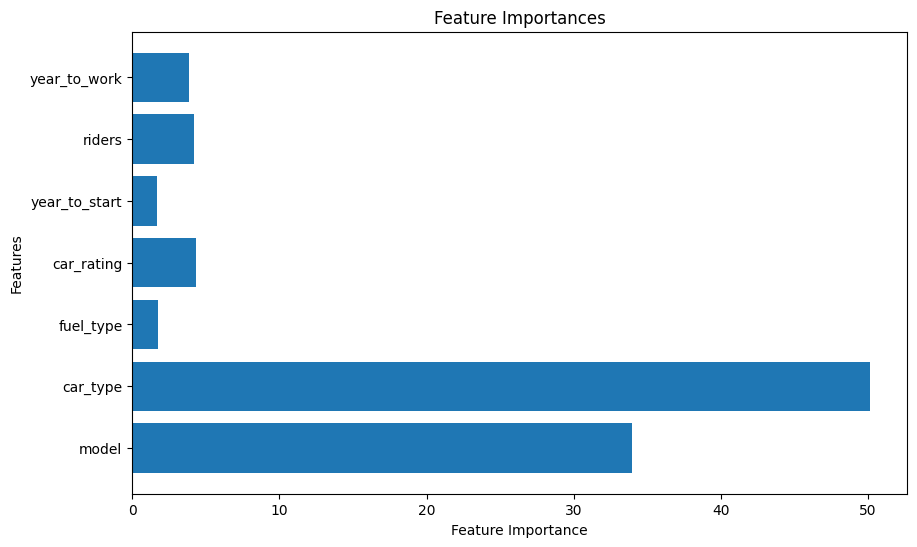

In [ ]:
# YOUR CODE HERE
feature_importance = clf.feature_importances_

# Создание графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).

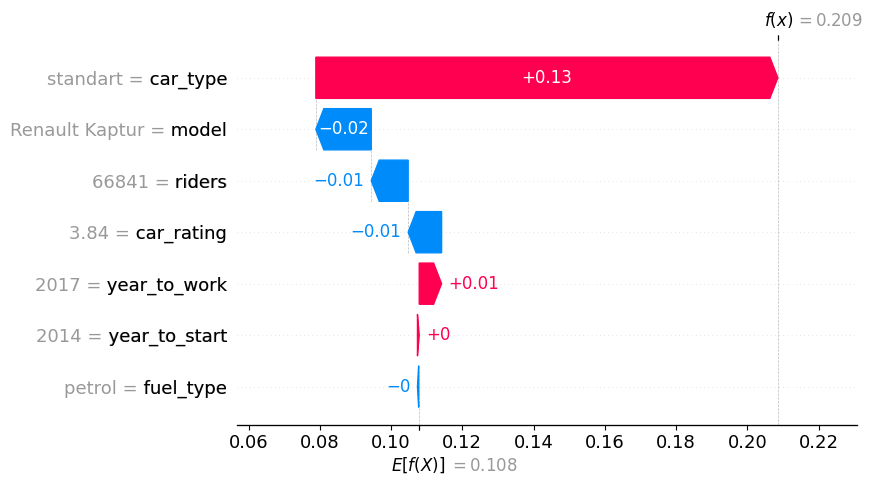

In [ ]:
import shap

s_values = explainer(X_test)
shap.waterfall_plot(s_values[0][:, 0])

3. Постройте `classification_report` из библиотеки `scikit-learn`.


In [ ]:
from sklearn.metrics import classification_report


print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=clf.classes_))

                 precision    recall  f1-score   support

    another_bug       0.16      0.22      0.19        55
      break_bug       0.18      0.23      0.20        48
    electro_bug       0.00      0.00      0.00        55
   engine_check       0.20      0.02      0.03        56
    engine_fuel       0.13      0.08      0.10        50
engine_ignition       0.12      0.31      0.17        48
engine_overheat       0.08      0.06      0.07        69
     gear_stick       0.10      0.24      0.14        49
    wheel_shake       0.50      0.03      0.05        38

       accuracy                           0.13       468
      macro avg       0.16      0.13      0.11       468
   weighted avg       0.15      0.13      0.10       468



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.

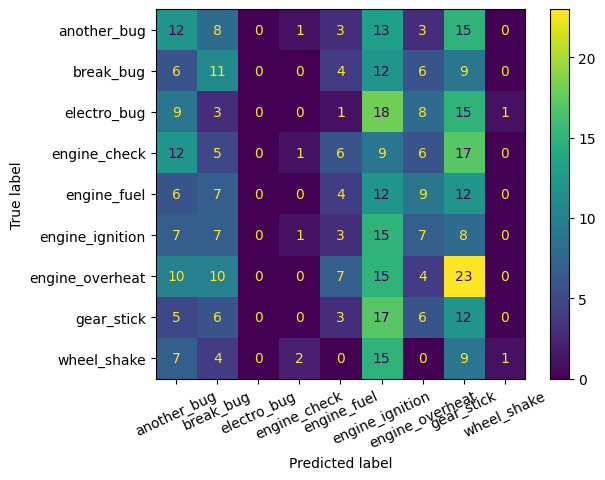

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, xticks_rotation = 25)

Выводы:

1) Feature Importances (важность признаков) - этот метод позволяет определить, какие признаки оказывают наибольшее влияние на модель. Чем выше значение важности признака, тем больше его вклад в прогнозы модели. При интерпретации важности признаков важно учитывать их направление влияния (положительное или отрицательное). Визуализация важности признаков может помочь выявить ключевые факторы, влияющие на целевую переменную.

2) Waterfall Plot с использованием SHAP - этот метод помогает визуализировать влияние каждого признака на предсказание модели для конкретного наблюдения. Каждый столбец на графике представляет собой вклад каждого признака в изменение прогноза модели от базового значения (ожидаемого значения). Сумма всех столбцов равна изменению прогноза относительно базового значения. Waterfall plot позволяет понять, какие признаки и в каком направлении вносят наибольший вклад в прогнозы модели для конкретного наблюдения.

3) Матрица ошибок (confusion matrix) - этот метод помогает оценить производительность модели, показывая количество верно и ошибочно классифицированных наблюдений для каждого класса. По диагонали матрицы находятся верно классифицированные наблюдения, а вне диагонали - ошибки классификации. Интерпретация матрицы ошибок помогает выявить, в каких классах модель делает наибольшее количество ошибок, что может указывать на слабые стороны модели и направления для ее улучшения.

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [9]:
# YOUR CODE HERE
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.7 MB/s eta 0:00:00


In [10]:
import optuna


In [11]:
CatBoostClassifier()


In [29]:
features2drop = ['car_id'] # то, что надо выбросить
targets = ['target_class', 'target_reg'] # таргеты
cat_features = ['car_type', 'fuel_type', 'model'] # категориальные признаки

num_features = ['car_rating', 'year_to_start', 'riders', 'year_to_work'] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

filtered_features = [i for i in car_train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

Категориальные признаки: 3 ['car_type', 'fuel_type', 'model']
Числовые признаки: 4 ['car_rating', 'year_to_start', 'riders', 'year_to_work']
Целевые переменные ['target_class', 'target_reg']


In [36]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split


def objective(trial, return_models=False):
    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    X_train = car_train[filtered_features].drop(targets, axis=1, errors="ignore")
    y_train = car_train["target_class"]

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        model, y_pred = fit_catboost(trial, train_data, valid_data)
        scores.append(accuracy_score(y_pred, valid_data[1]))
        models.append(model)
        break


    result = np.mean(scores)

    if return_models:
        return result, models
    else:
        return result

In [37]:
def fit_catboost(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'iterations' : 100,
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 50),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.8),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "10gb",
        "eval_metric": "Accuracy",
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced", "None"]),
        "depth": trial.suggest_int("depth", 3, 9),
    }


    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 20)

    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)


    clf = CatBoostClassifier(
        **param,
        thread_count=-1,
        random_seed=88,
        cat_features=cat_features,
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=0,
        plot=False,
        early_stopping_rounds=5,
    )

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [32]:
study = optuna.create_study(direction="maximize")
study.optimize(objective,
               n_trials=1000,
               n_jobs = -1,
               show_progress_bar=True,)

[I 2024-03-30 11:57:29,734] A new study created in memory with name: no-name-ac3d04a9-d552-4cbc-97de-08099b51d190


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-03-30 11:57:29,957] Trial 1 finished with value: 0.11810012836970475 and parameters: {'learning_rate': 0.009924628648598863, 'l2_leaf_reg': 7, 'colsample_bylevel': 0.782727419967718, 'auto_class_weights': 'None', 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.11810012836970475.
[I 2024-03-30 11:57:30,347] Trial 2 finished with value: 0.10526315789473684 and parameters: {'learning_rate': 0.0037503173570353544, 'l2_leaf_reg': 6, 'colsample_bylevel': 0.3212305413139879, 'auto_class_weights': 'SqrtBalanced', 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.11957467803694044}. Best is trial 1 with value: 0.11810012836970475.
[I 2024-03-30 11:57:30,575] Trial 0 finished with value: 0.11553273427471117 and parameters: {'learning_rate': 0.003046345068241007, 'l2_leaf_reg': 10, 'colsample_bylevel': 0.448290336323151, 'auto_class_weights': 'None', 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'M

RuntimeError: Attempt to pop from an empty stack

In [33]:
print("Лучшие: score {}, параметры {}".format(study.best_trial.value, study.best_trial.params))


Лучшие: score 0.13093709884467267, параметры {'learning_rate': 0.008761215635951222, 'l2_leaf_reg': 10, 'colsample_bylevel': 0.7651171008890212, 'auto_class_weights': 'None', 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.16426360357824}


In [34]:
valid_scores, models = objective(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True,
)

In [35]:
print("Valid scores: {}, length: {}".format(valid_scores, len(models)))


Valid scores: 0.13093709884467267, length: 1


Выводы: Разницы не заметил. Возможно это связано с ранним прерыванием первого обучения, но мне не удалось подобрать параметры, чтобы этого не происходило.

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [63]:
# YOUR CODE HERE
import lightgbm as lgbm
import xgboost as xgb
import catboost as cb

import warnings
warnings.filterwarnings("ignore")

In [41]:
cat_cols = ["model", "car_type", "fuel_type"]
for col in cat_cols:
    car_train[col] = car_train[col].replace(np.unique(car_train[col]), np.arange(car_train[col].nunique()))
    car_train[col] = car_train[col].astype("category")

car_train.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
0,y13744087j,8,1,1,3.78,2015,76163,2021,108.53,another_bug
1,O41613818T,23,1,1,3.90,2015,78218,2021,35.20,electro_bug
2,d-2109686j,16,3,1,6.30,2012,23340,2017,38.62,gear_stick
3,u29695600e,12,0,1,4.04,2011,1263,2020,30.34,engine_fuel
4,N-8915870N,16,3,1,4.70,2012,26428,2017,30.45,engine_fuel


In [44]:
cols2drop = ["car_id", "target_reg", "target_class"]

X_train, X_val, y_train, y_val = train_test_split(
    car_train.drop(cols2drop, axis=1),
    car_train["target_reg"],
    test_size=0.25,
    stratify=car_train["target_class"],
    random_state=42,
)
print(X_train.shape, X_val.shape)

(1752, 7) (585, 7)


### 1. CatBoost

In [45]:
params_cat = {
    "n_estimators": 1000,
    "learning_rate": 0.02,
    "depth": 3,
    "use_best_model": True,
    "cat_features": cat_cols,
    "text_features": [],
    "loss_function": "RMSE",
    "random_state": 42,
    "custom_metric": ["MAE", "MAPE"],
    "border_count": 32,
    "l2_leaf_reg": 1,
    "bagging_temperature": 3,
    "rsm": 0.6,
}

cat_model = cb.CatBoostRegressor(**params_cat)
cat_model.fit(
    X_train,
    y_train,
    verbose=100,
    eval_set=(X_val, y_val),
    early_stopping_rounds=150,
)

0:	learn: 17.4596993	test: 17.8587239	best: 17.8587239 (0)	total: 994us	remaining: 993ms
100:	learn: 16.9495990	test: 17.4998083	best: 17.4986638 (98)	total: 312ms	remaining: 2.78s
200:	learn: 16.8324941	test: 17.5228039	best: 17.4986638 (98)	total: 646ms	remaining: 2.57s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 17.49866377
bestIteration = 98

Shrink model to first 99 iterations.


In [47]:
from sklearn.metrics import mean_squared_error
print('MSE from Catboost: ', mean_squared_error(cat_model.predict(X_val), y_val).round(3))

MSE from Catboost:  306.203


In [51]:
mean_squared_error(np.ones(len(y_val)) * y_val.mean(), y_val).round(3)
submit = pd.DataFrame({"target": cat_model.predict(X_val).reshape(-1)})
submit.to_csv("catboost_preds.csv", index=False)
submit.head()

,target
0,44.486969
1,44.277655
2,44.126354
3,44.261047
4,43.798593


### 2. LGBM

In [55]:
pip install tabgan==1.3.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 763.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [64]:
params_lgbm = {
    "num_leaves": 200,
    "n_estimators": 1500,
    "max_depth": 7,
    "min_child_samples": 2073,
    "learning_rate": 0.0051,
    "min_data_in_leaf": 10,
    "feature_fraction": 0.99,
    "categorical_feature": cat_cols,
    'reg_alpha' : 5.0,
    'reg_lambda' : 5.0,
}


lgbm_model = lgbm.LGBMRegressor(**params_lgbm)

lgbm_model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=2073 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.99, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.99
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=2073 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.99, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.99
[LightGBM] [Warning] categorical_feature is set=model,car_type,fuel_type, categorical_column=0,1,2 will be ignored. Current value: categorical_feature=model,car_type,fuel_type
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1752, number of used features: 7
[LightGBM] [Warning] min_data_in_leaf 

LGBMRegressor(categorical_feature=['model', 'car_type', 'fuel_type'],
              feature_fraction=0.99, learning_rate=0.0051, max_depth=7,
              min_child_samples=2073, min_data_in_leaf=10, n_estimators=1500,
              num_leaves=200, reg_alpha=5.0, reg_lambda=5.0)

In [65]:
print('MSE from LightGBM : ', mean_squared_error(lgbm_model.predict(X_val), y_val).round(3))


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=2073 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.99, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.99
MSE from LightGBM :  331.191


In [66]:
submit = pd.DataFrame({"target": lgbm_model.predict(X_val).reshape(-1)})
submit.to_csv("lgbm_preds.csv", index=False)
submit.head()

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=2073 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.99, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.99


,target
0,40.006341
1,44.345362
2,46.015902
3,40.430846
4,51.088690


### 3. XGBoost

In [67]:
X_train = pd.get_dummies(X_train, columns=["car_type", "fuel_type", "model"])
X_val = pd.get_dummies(X_val, columns=["car_type", "fuel_type", "model"])
X_train.shape

(1752, 36)

In [68]:
params_xgb = {
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    'gamma': .01,
    'reg_lambda' : 0.1,
    'reg_alpha' : 0.5,
    "objective": "reg:linear",
    "eval_metric": "mae",
    'tree_method' : 'hist',
    'enable_categorical' : True

}

xgb_model = xgb.XGBRegressor(**params_xgb)

xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    early_stopping_rounds=100,
    verbose=25,
)
print('Лучша итерация', xgb_model.best_iteration)

[0]	validation_0-mae:13.69537	validation_1-mae:13.89182
[25]	validation_0-mae:12.90692	validation_1-mae:13.75931
[50]	validation_0-mae:12.34690	validation_1-mae:13.74455
[75]	validation_0-mae:11.85445	validation_1-mae:13.79589
[99]	validation_0-mae:11.44050	validation_1-mae:13.84792
Лучша итерация 43


In [69]:
print('MSE from XGBoost : ', mean_squared_error(xgb_model.predict(X_val), y_val).round(3))


MSE from XGBoost :  309.897


In [70]:
submit = pd.DataFrame({"target": xgb_model.predict(X_val).reshape(-1)})
submit.to_csv("xgb_preds.csv", index=False)
submit.head()

,target
0,44.298943
1,45.649933
2,43.150864
3,43.875793
4,42.629238


### Блендинг

In [71]:
cb_model  = pd.read_csv("catboost_preds.csv")["target"]
xgb_model = pd.read_csv("xgb_preds.csv")["target"]
lgb_model = pd.read_csv("lgbm_preds.csv")["target"]

In [74]:
all = cb_model * 0.50 + xgb_model * 0.35 + lgb_model * 0.15


In [75]:
print('MSE all :', mean_squared_error(all, y_val).round(3))


MSE all : 307.077


In [76]:
round((100*(132.051 - 131.080)/132.051), 1)


0.7

In [79]:
import os

preds = pd.DataFrame()
weights = {"catboost": 0.5, "lgbm": 0.15, "xgb": 0.35}

for model_name in ["catboost", "lgbm", "xgb"]:

    path = os.path.join("", f"{model_name}_preds.csv")
    now = pd.read_csv(path).reset_index()
    now["model"] = model_name
    now["target"] *= weights[model_name]
    preds = pd.concat([preds, now])

preds.head()

,index,target,model
0,0,22.243484,catboost
1,1,22.138828,catboost
2,2,22.063177,catboost
3,3,22.130524,catboost
4,4,21.899297,catboost


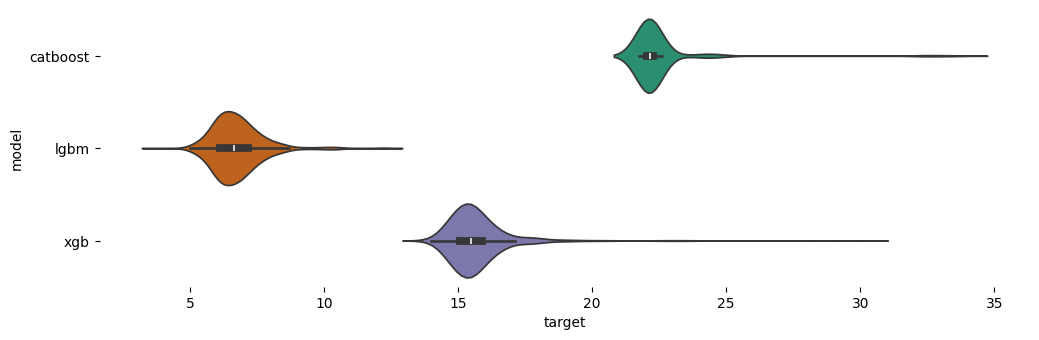

In [81]:

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(preds['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(preds, x='target', y='model', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [83]:

e = preds.groupby("index")["target"].agg("sum")
mean_squared_error(e, y_val)


307.0766250702459

Вывод:

Блендинг - это очень крутой и сильный инструмент, который зачастую занчительно улучшает качество моделей.
При этом смешивание можно проводить довольно просто и с минимальным написанием кода.
Хотя стекинг дает ощутимее результаты, чем блендинга. Но и там свои нюансы есть.


### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [84]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017


In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.